In [ ]:
#!pip install transformers

Roughly following https://colab.research.google.com/github/jalammar/jalammar.github.io/blob/master/notebooks/bert/A_Visual_Notebook_to_Using_BERT_for_the_First_Time.ipynb#scrollTo=URn-DWJt5xhP

plus 
https://wandb.ai/wandb/common-ml-errors/reports/How-To-Use-GPU-with-PyTorch---VmlldzozMzAxMDk


In [1]:
import numpy as np
import pandas as pd
import torch
import transformers


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.cuda.is_available()


True

In [3]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = transformers.DistilBertModel.from_pretrained('distilbert-base-uncased')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
co = [
"Use all features of Java programming language.",
"Use most of the packages in the core Java API.",
"Trace the activity of a program using the contour model.",
"Complete at least 10 well-written Java programs.",
]

slo = [
"       Students create computer programs using all of the features of the Java programming language in the core Java API.",
"Students work as a team to design implement and test the project using java tools."
]


In [5]:
tokenized = map((lambda x: tokenizer.encode(x, add_special_tokens=True)), co)

In [6]:
tokenized = list(tokenized)

In [7]:
max_len = 0
for i in tokenized:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized])

In [8]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(4, 14)

In [9]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)


In [10]:
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
model = model.to(device)

In [11]:
with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [12]:
# embedding of whole snippet
features = last_hidden_states[0][:,0,:]

In [15]:
features_np = features.cpu().numpy()

In [ ]:
#!pip install umap-learn

In [14]:
import umap

In [16]:
reducer = umap.UMAP()

In [17]:
embedding = reducer.fit_transform(features_np)


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
/usr/local/lib/python3.7/dist-packages/umap/umap_.py:2345: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns


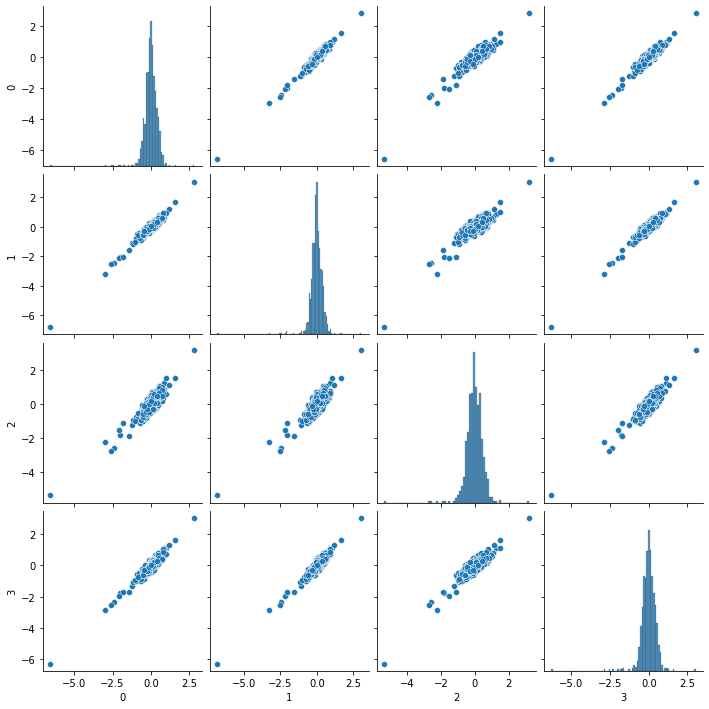

In [21]:
sns.pairplot(pd.DataFrame(features_np.T))

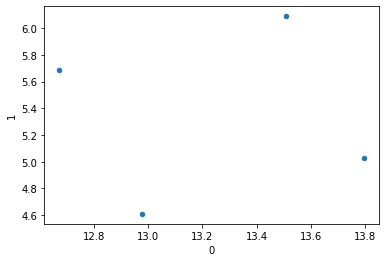

In [27]:
pd.DataFrame(embedding).plot.scatter(0,1)

In [24]:
embedding

array([[12.67371  ,  5.68926  ],
       [13.50724  ,  6.0881467],
       [12.978971 ,  4.6094675],
       [13.794963 ,  5.024728 ]], dtype=float32)

# check slos vs cos

In [28]:
tokenized = map((lambda x: tokenizer.encode(x, add_special_tokens=True)), slo)

In [29]:
tokenized = list(tokenized)

In [30]:
max_len = 0
for i in tokenized:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized])

In [31]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(2, 22)

In [32]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)


In [33]:
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
#model = model.to(device)

In [34]:
with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [35]:
# embedding of whole snippet
features = last_hidden_states[0][:,0,:]

In [37]:
features_np_slo = features.cpu().numpy()

In [38]:
embedding_slo = reducer.transform(features_np_slo)

In [39]:
embedding_slo

array([[14.8685055,  6.611812 ],
       [14.961977 ,  6.4219127]], dtype=float32)

In [42]:
import plotnine as p9

In [53]:
co_df = pd.DataFrame(embedding,   columns=['x', 'y'])
co_df['type'] = 'co'
co_df['text'] = co

In [54]:
slo_df = pd.DataFrame(embedding_slo, columns=['x', 'y'])
slo_df['type'] = 'slo'
slo_df['text'] = slo

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


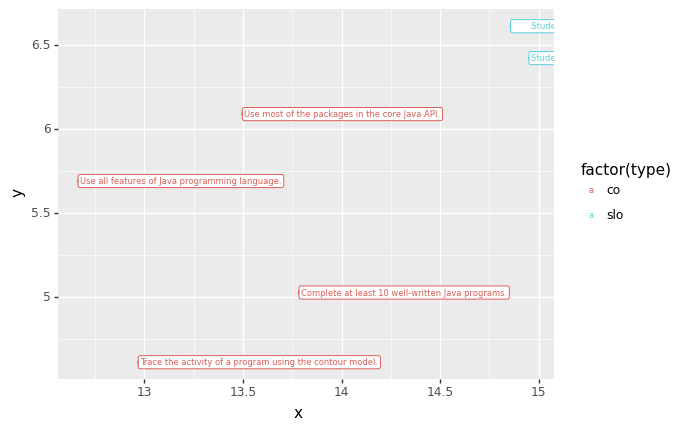

<ggplot: (8752264575237)>

In [64]:
p9.ggplot(pd.concat([co_df, slo_df])) + p9.aes(x='x', y='y', color='factor(type)', label='text') + p9.geom_point() + p9.geom_label(size=6, hjust='left')

In [70]:
from  pprint import pprint as print
print(co)
print(slo)

['Use all features of Java programming language.',
 'Use most of the packages in the core Java API.',
 'Trace the activity of a program using the contour model.',
 'Complete at least 10 well-written Java programs.']
['       Students create computer programs using all of the features of the '
 'Java programming language in the core Java API.',
 'Students work as a team to design implement and test the project using java '
 'tools.']


In [67]:
# from features directly
distance = np.array(
    [[ np.linalg.norm( features_np[c,:] - features_np_slo[s,:]     )   for c in range(4)   ] for s in range(2)]


)
distance

array([[5.262249 , 4.842022 , 7.3032637, 5.5460525],
       [6.3388534, 5.7002225, 8.042542 , 6.487018 ]], dtype=float32)

In [69]:
# from umap embedding directly
distance = np.array(
    [[ np.linalg.norm( embedding[c,:] - embedding_slo[s,:]     )   for c in range(4)   ] for s in range(2)]


)
distance

array([[2.3808045, 1.4585158, 2.7531302, 1.9160715],
       [2.4026957, 1.4925343, 2.6864982, 1.8204525]], dtype=float32)